# COGS 108 - Final Project 

# Overview

The common frequency of restaurant inspection is once in six months. If a restaurant has severe issues, it usually get inspected more than twice a year. In the dataset I use, the issues can be reflected by inspection score, number of critical issues, number of non-critical issues. However, there is no statistically significant relationship between frequency of inspection and any variables mentioned above. 

# Name & PID

- Name: Yingzi Jin
- PID: A15099906

# Research Question

Does the inspectors inspect the facilities that have relatively low scores/more critical issues more often? Does the food safety level of the neighborhood affect the frequency of the inspection?

## Background and Prior Work

References (include links):
- 1)  https://www.news4jax.com/news/2017/07/21/how-often-are-restaurants-checked-by-state-inspectors/
    
    This article provides some information about frequency of inspection:
    Since restaurants cook raw food, then they are in the level 2. Thus, they get inspected at least twice a year. 
    If the restaurants are violators before, they can get inspected more, around three times per year, even more frequently.


- 2)  https://www.rhinotimes.com/archives/state-made-harder-inspect-restaurants-fewer-get-inspected/

    This article states that it is increasingly difficult to do inspection. It has very complex processes and takes longer time. Therefore, the inspection rate is not very high. This can prevent the inspectors to do more inspections. 

# Hypothesis


The restaurants that have lower inspection scores, more critical issues, or more non-critical issues would be inspected more often.

Based on my first reference, the facilities that violate the rules before should get more frequent inspections. This is also reasonable because these facilities have more potential to make violations again. However, the second reference reminds me that the practicality of increasing the frequency of inspections is questionable. Therefore, this project is aimed at understanding the situation in reality. 

# Dataset(s)


- Dataset Name: inspection.csv (COGS108 Canvas)
- Link to the dataset:https://canvas.ucsd.edu/courses/12630/files?
- Number of observations: 18466

This dataset contains detailed information about inspections of food facilities that were made bewteen 2012-09 and 2016-11 in North Carolina . 

# Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import normaltest

# Data Cleaning

Describe your data cleaning steps here.

In [118]:
df = pd.read_csv('/home/yij138/FinalProject/inspections.csv')
df = df[df['facilitytype']=='Restaurant'] #Extract the restaurants
df = df[['hsisid','inspection_num','days_since_previous_inspection','score','num_critical','num_non_critical','avg_neighbor_num_critical','avg_neighbor_num_non_critical']]

In [119]:
#Calculate the frequency
df_avg = df.groupby('hsisid').agg('mean')
df_avg['frequency'] = df_avg['days_since_previous_inspection']
df_avg = df_avg.reset_index()

In [120]:
#Add a frequency column
df_f = df_avg[['hsisid','frequency']]
df = pd.merge(df, df_f, on='hsisid')

In [121]:
df = df.dropna(subset=['frequency']) #drop all the rows whose frequency columns are null 
df = df[['hsisid','inspection_num','score','num_critical',
         'num_non_critical','avg_neighbor_num_critical',
         'avg_neighbor_num_non_critical','frequency']]

# Data Analysis & Results

Include cells that describe the steps in your data analysis.

In [122]:
#Have a general understanding of the dataset
df.describe()
#We can see the average frequency is around once in 200 days, 20 days longer than 6 months (180 days)

,hsisid,inspection_num,score,num_critical,num_non_critical,avg_neighbor_num_critical,avg_neighbor_num_non_critical,frequency
count,1.182700e+04,11827.000000,11827.000000,11827.000000,11827.000000,11823.000000,11823.000000,11827.000000
mean,4.092015e+09,4.038302,95.661875,3.351399,5.931513,3.416094,5.787281,200.562781
std,1.818725e+03,2.367969,2.719702,3.045730,3.843049,1.590063,2.095196,53.847462
min,4.092010e+09,1.000000,72.500000,0.000000,0.000000,0.000000,0.800000,0.000000
25%,4.092014e+09,2.000000,94.500000,1.000000,3.000000,2.200000,4.367262,167.375000
50%,4.092015e+09,4.000000,96.000000,3.000000,5.000000,3.200000,5.480000,189.000000
75%,4.092016e+09,6.000000,97.500000,5.000000,8.000000,4.347619,6.850000,224.500000
max,4.092017e+09,16.000000,100.000000,23.000000,33.000000,10.446667,16.333333,637.000000


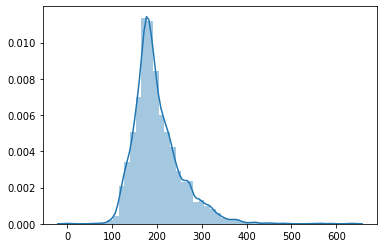

In [123]:
#Get the general understanding of the distribution of the frequency
df_f = df[['frequency']]

sns.distplot(df_f) #Does not spread out much, but has very long tails, which means that it has several outliers

In [124]:
df = df[df['frequency']<=400] #focus on the majority of the frequency

In [125]:
#Check the normality
f = df_f['frequency']
st_f, p_f = stats.normaltest(f)
p_f < 0.05 #The output is True. Therefore, the frequency is not normally distributed. 

True

In [126]:
#First, I want to know whether the restaurants that got lower score violations in the first inspection would be inspected more frequently 
df_1 = df[df['inspection_num']==1]
df_1.corr() #get a general understsanding of the correlation, very trivial correlation between frequency and scores 

,hsisid,inspection_num,score,num_critical,num_non_critical,avg_neighbor_num_critical,avg_neighbor_num_non_critical,frequency
hsisid,1.000000,NaN,0.007295,-0.075580,-0.240640,-0.088014,-0.082438,-0.119632
inspection_num,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,0.007295,NaN,1.000000,-0.627074,-0.569906,-0.173994,-0.130617,0.038525
num_critical,-0.075580,NaN,-0.627074,1.000000,0.487044,0.405077,0.254058,-0.002281
num_non_critical,-0.240640,NaN,-0.569906,0.487044,1.000000,0.313241,0.397988,0.017745
avg_neighbor_num_critical,-0.088014,NaN,-0.173994,0.405077,0.313241,1.000000,0.590921,0.026204
avg_neighbor_num_non_critical,-0.082438,NaN,-0.130617,0.254058,0.397988,0.590921,1.000000,0.025738
frequency,-0.119632,NaN,0.038525,-0.002281,0.017745,0.026204,0.025738,1.000000


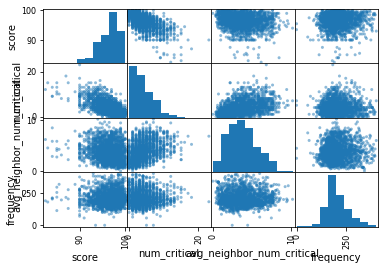

In [109]:
from pandas.plotting import scatter_matrix
df_corr = df_1[['score','num_critical','avg_neighbor_num_critical','frequency']]
fig = scatter_matrix(df_corr)
#The scatter plots of frequency and other factors are very flat, so the correlation might be very small 

In [110]:
#Explore the data with relatively low scores
df_low = df_1[df_1['score']<90] #'90' is the dividing line between letter grade 'A' and 'B'
df_low.corr() #Has a higher correlation rate 

,hsisid,inspection_num,score,num_critical,num_non_critical,avg_neighbor_num_critical,avg_neighbor_num_non_critical,frequency
hsisid,1.000000,NaN,-0.197574,-0.680615,-0.432420,-0.216143,-0.128255,-0.276548
inspection_num,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,-0.197574,NaN,1.000000,-0.108552,-0.540374,0.009346,-0.325646,0.288920
num_critical,-0.680615,NaN,-0.108552,1.000000,0.591405,-0.075983,-0.153977,0.284576
num_non_critical,-0.432420,NaN,-0.540374,0.591405,1.000000,-0.074327,0.311478,-0.072178
avg_neighbor_num_critical,-0.216143,NaN,0.009346,-0.075983,-0.074327,1.000000,0.625553,0.162510
avg_neighbor_num_non_critical,-0.128255,NaN,-0.325646,-0.153977,0.311478,0.625553,1.000000,-0.249234
frequency,-0.276548,NaN,0.288920,0.284576,-0.072178,0.162510,-0.249234,1.000000


In [111]:
#Make a scatterplot to see this relationship
a1, b1 = np.polyfit(df_low['score'], df_low['frequency'], 1)

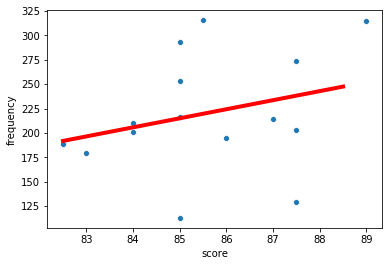

In [112]:
sns.scatterplot(df_low['score'], df_low['frequency'])
xs = np.arange(min(df_low['score']),max(df_low['score']))
ys = a1 * xs + b1
plt.plot(xs, ys, '-r', linewidth=4)

In [113]:
#Create a linear model to predict score from frequency 
outcome_1, predictors_1 = patsy.dmatrices('score~frequency',df_low)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()

In [114]:
print(res_1.summary())
#The p-value is large than 0.05, so there is no statistically significant correlation between frequency and inspection scores

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.275
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.278
Time:                        23:22:34   Log-Likelihood:                -31.079
No. Observations:                  16   AIC:                             66.16
Df Residuals:                      14   BIC:                             67.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     83.4954      1.805     46.261      0.0

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


In [90]:
outcome_2, predictors_2 = patsy.dmatrices('num_critical~frequency',df_low)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()

In [91]:
print(res_2.summary())
#The p_value is also very large. There is no statistically significant correlation between number of critical violations and the frequency.

                            OLS Regression Results                            
Dep. Variable:           num_critical   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.234
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.285
Time:                        23:19:57   Log-Likelihood:                -39.716
No. Observations:                  16   AIC:                             83.43
Df Residuals:                      14   BIC:                             84.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1697      3.097      2.638      0.0

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


In [92]:
outcome_3, predictors_3 = patsy.dmatrices('avg_neighbor_num_critical~frequency',df_low)
mod_3 = sm.OLS(outcome_3, predictors_3)
res_3 = mod_3.fit()

In [93]:
print(res_3.summary())
#Again, p-value is very large. 

                                OLS Regression Results                               
Dep. Variable:     avg_neighbor_num_critical   R-squared:                       0.026
Model:                                   OLS   Adj. R-squared:                 -0.043
Method:                        Least Squares   F-statistic:                    0.3798
Date:                       Wed, 10 Jun 2020   Prob (F-statistic):              0.548
Time:                               23:19:59   Log-Likelihood:                -31.018
No. Observations:                         16   AIC:                             66.04
Df Residuals:                             14   BIC:                             67.58
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


In [94]:
outcome_4, predictors_4 = patsy.dmatrices('avg_neighbor_num_non_critical~frequency',df_low)
mod_4 = sm.OLS(outcome_4, predictors_4)
res_4 = mod_4.fit()

In [95]:
print(res_4.summary()) #No statistically significant relationship 

                                  OLS Regression Results                                 
Dep. Variable:     avg_neighbor_num_non_critical   R-squared:                       0.062
Model:                                       OLS   Adj. R-squared:                 -0.005
Method:                            Least Squares   F-statistic:                    0.9272
Date:                           Wed, 10 Jun 2020   Prob (F-statistic):              0.352
Time:                                   23:20:01   Log-Likelihood:                -36.868
No. Observations:                             16   AIC:                             77.74
Df Residuals:                                 14   BIC:                             79.28
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


In [96]:
#Second, I want to see if the restaurants that have lower average scores would get inspected more.
df_avg.corr() #the correlation rate is still very small

,hsisid,inspection_num,days_since_previous_inspection,score,num_critical,num_non_critical,avg_neighbor_num_critical,avg_neighbor_num_non_critical,frequency
hsisid,1.000000,-0.483873,-0.097107,0.042411,-0.008188,-0.190646,-0.040360,-0.106525,-0.097107
inspection_num,-0.483873,1.000000,-0.425403,-0.062781,0.056852,0.197597,0.026070,0.072738,-0.425403
days_since_previous_inspection,-0.097107,-0.425403,1.000000,0.069338,-0.050390,-0.039600,0.067348,0.024677,1.000000
score,0.042411,-0.062781,0.069338,1.000000,-0.770165,-0.720471,-0.225301,-0.148565,0.069338
num_critical,-0.008188,0.056852,-0.050390,-0.770165,1.000000,0.604973,0.375830,0.238817,-0.050390
num_non_critical,-0.190646,0.197597,-0.039600,-0.720471,0.604973,1.000000,0.213035,0.371543,-0.039600
avg_neighbor_num_critical,-0.040360,0.026070,0.067348,-0.225301,0.375830,0.213035,1.000000,0.586345,0.067348
avg_neighbor_num_non_critical,-0.106525,0.072738,0.024677,-0.148565,0.238817,0.371543,0.586345,1.000000,0.024677
frequency,-0.097107,-0.425403,1.000000,0.069338,-0.050390,-0.039600,0.067348,0.024677,1.000000


In [97]:
#statistically significant?
outcome_5, predictors_5 = patsy.dmatrices('score~frequency',df_avg)
mod_5 = sm.OLS(outcome_5, predictors_5)
res_5 = mod_5.fit()
print(res_4.summary())
#No statistical significance 

                                  OLS Regression Results                                 
Dep. Variable:     avg_neighbor_num_non_critical   R-squared:                       0.062
Model:                                       OLS   Adj. R-squared:                 -0.005
Method:                            Least Squares   F-statistic:                    0.9272
Date:                           Wed, 10 Jun 2020   Prob (F-statistic):              0.352
Time:                                   23:20:05   Log-Likelihood:                -36.868
No. Observations:                             16   AIC:                             77.74
Df Residuals:                                 14   BIC:                             79.28
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


# Ethics & Privacy

- The original dataset is from the instructor of COGS108. Therefore, I am allowed to use this dataset.
- The original dataset contains private information such as the name, location, zipcode, geographical information(longitude and latitude) of the facilities. Since my project does not need any of it, I deleted all the private information. The "hsisid" is an unique id for every inspected facility, which can be regarded as private information. Therefore, I would not mention any specific id in my report. 
- According to the second reference, the inspection rate is not very high. Thus, many facilities may be not inspected and the dataset has no information of these facilities. I would regard this dataset as a sample from the population, not the population itself.

# Conclusion & Discussion

- The inspectors are asked to pay more attention to the restaurants that have lower inspection scores or have more violations. However, the cost of making the inspection may prevent them from actually inspecting these restaurants more. Based on this dataset, I made several linear prediction model between frequency and inspection scores (and other factors related to scores). However, the p-values of these model are very large, and the coefficients are quite small. I did not find statistically significant relationship between the frequency and the score, which is opposed to my hypothesis. 
- The limitations of my project
    - The dataset can be biased. Based on the second reference, it is increasingly difficult and time-consuming to make an inspection because the process becomes more complex. Thus, if the local goverment wants to increase the inspection rate, they may start to inspect the restaurants that have good record, which have less probability to severely violate the rules. Then the process can be easier and faster. Therefore, the dataset may be more about the restaurants that are in a good standing.
    - Different cities and states have different situations.
- This project is to discover the difference between the ideal policy and the reality. Although we hope that the local government can make more effort on food safety, the cost of making more inspections can be tremendous, which does not allow them to do what we hope they can do. 